In [1]:
import matplotlib
from IPython.display import display
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
plt.rcParams['figure.figsize'] = [18, 20]

from pprint import pprint
from scipy.optimize import minimize, Bounds, LinearConstraint, fsolve
# from scipy.special import seterr
# seterr(singular="ignore")

import numpy as np
import copy
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()
import pandas as pd
import time as time_lib
import os
from gurobipy import GRB, Model, quicksum
matplotlib.__version__

'3.4.2'

# Helper Classes and Functions

In [2]:
class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())
        
afmhot = matplotlib.cm.get_cmap('afmhot', 512)
newcolors = afmhot(np.linspace(0, 1, 512))
bg = np.array([200/256, 220/256, 250/256, 1])
newcolors[:1, :] = bg
afmhot_with0 = matplotlib.colors.ListedColormap(newcolors)

In [3]:
# chooses optimal random probabilities to optimize costs (note this only works for mu 1 vector, I believe)
def randOptimize():
    bounds = Bounds([1] + [0 for i in range(1, n)], [1 for i in range(n)])
    objective = lambda alpha: sum([c[j]*lamb[j]/(alpha[j]*mu[2*j]+(1-alpha[j+1])*mu[2*(j+1)-1]-lamb[j]) for j in range(n-1)]) + c[n-1]*lamb[n-1]/(alpha[n-1]*mu[2*(n-1)] - lamb[n-1])
    denom_constr = LinearConstraint([[0 for i in range(j)] + [mu[2*j], -mu[2*(j+1)-1]] + [0 for i in range(j+2, n)] for j in range(n-1)] + [[0 for j in range(n-1)] + [mu[2*(n-1)]]],
                                     [lamb[j] - mu[2*(j+1)-1] for j in range(n-1)] + [lamb[n-1]],
                                     [np.inf for j in range(n)])#, keep_feasible=True)
    res = minimize(objective, [1] + [1 for i in range(1, n)], method='trust-constr',
               options={'disp': False, 'xtol':1e-40,}, bounds=bounds, constraints=[denom_constr]) # 'xtol':1e-13, 
#     newfig = plt.figure()
#     plt.plot([i/1000 for i in range(int((1-epsilon/n)*1000)+1, 1001)], [objective([1, i/1000]) for i in range(int((1-epsilon/n)*1000)+1, 1001)])
#     display(newfig)
#     pprint(objective(res.x))
#     pprint(objective([1 for j in range(n)]))
    pprint(res.x)
    return(res.x)

def randFunc(alpha):
    term1 = [-c[0]*lamb[0]*mu[0]/(alpha[0]*mu[0]+(1-alpha[1])*mu[1]-lamb[0])**2] + [
             -c[j]*lamb[j]*mu[2*j]/(alpha[j]*(mu[2*j])+(1-alpha[j+1])*mu[2*(j+1)-1]-lamb[j])**2 + -c[j-1]*lamb[j-1]*-mu[2*j-1]/(alpha[j-1]*mu[2*(j-1)]+(1-alpha[j])*mu[2*j-1]-lamb[j-1])**2 for j in range(1, n-1)] + [
             -c[n-1]*lamb[n-1]*mu[2*(n-1)]/(alpha[n-1]*(mu[2*(n-1)])-lamb[n-1])**2 + -c[(n-1)-1]*lamb[(n-1)-1]*-mu[2*(n-1)-1]/(alpha[(n-1)-1]*mu[2*((n-1)-1)]+(1-alpha[n-1])*mu[2*(n-1)-1]-lamb[(n-1)-1])**2]
    term2 = [alpha[n-1 + 0]*-mu[0]] + [
             alpha[n-1 + j-1]*mu[2*j-1] + alpha[n-1 + j]*-mu[2*j] for j in range(1, n)]
    term3 = [alpha[2*(n-1) + j] for j in range(n)]
    term4 = [-alpha[3*(n-1) + j] for j in range(n)]
    term5 = [alpha[-1]] + [0 for i in range(1, n)]
    stationarity = [term1[i] + term2[i] + term3[i] + term4[i] + term5[i] for i in range(len(term1))]
    
    comp_slack = [alpha[n-1 + j] * - (alpha[j]*mu[2*j] + (1-alpha[j+1])*mu[2*(j+1)-1]-lamb[j]) for j in range(n-1)] + [
                  alpha[n-1 + n-1] * -(alpha[n-1]*mu[2*(n-1)]-lamb[n-1])] + [
                  alpha[2*(n-1) + j] * (alpha[j]-1) for j in range(n)] + [
                  alpha[3*(n-1) + j] * - alpha[j] for j in range(n)]
    
    
    return stationarity + comp_slack + [alpha[0]-1]


def randOptimize():
    init = 4 * [1 for j in range(n)] + [1]
#     func_sum = lambda alpha: [sum([-c[j]*lamb[j] * (alpha[j]*mu[2*j] + (1-alpha[j+1])*mu[2*(j+1)-1]-lamb[j])**(-2) for j in range(n-1)]) + c[n-1]*mu[n-1] * (alpha[n-1]*mu[2*(n-1)]-lamb[n-1])**(-2)*mu[2*(n-1)] + sum([alpha[n-1 + j] * (-mu[2*j] - (-mu[2*(j+1)-1])) for j in range(n-1)]) + alpha[n-1 + n-1] * (- mu[2*(n-1)]) -alpha[-1],
                              
                              
    
    root = fsolve(randFunc, init, xtol=1e-25, factor = 1e-6) #, method='trust-constr', options={'disp': False, 'xtol':1e-40,}, bounds=bounds, constraints=[denom_constr]) # 'xtol':1e-13, 
    pprint(list(root[:n]))
    pprint(randFunc(root))
    return([1] + list(root[1:n]))

def MaxWeight():
#     objective = lambda decision: sum([gamma[j] * Lq[j] ** beta * ((decision[j] <= 0.5)*mu[2*j] + (decision[j+1] > 0.5)*mu[2*(j+1)-1]) for j in range(n-1)]) + gamma[n-1] * Lq[n-1] ** beta * ((decision[n-1] > 0.5)*mu[2*(n-1)])
#     bounds = Bounds([1] + [0 for i in range(1, n)], [1 for i in range(n)])
#     res = minimize(objective, [1] + [0 for j in range(1, n)], method='trust-constr',
#                   options={'xtol':1e-13, 'disp': False}, bounds=bounds)
#     return [int(i>0.5) for i in res.x]
    # create the model
    d = Model('MaxWeight Decisions')
    d.setParam("LogToConsole", 0)

    # %% add decision variables
    x = d.addVars(range(n), vtype = GRB.BINARY if time_mode == "continuous" else GRB.CONTINUOUS, name = 'x')

    # %% add constraints
    d.addConstr((x[0] == 1), name = "first server serves first queue")

    # define objective
    if time_mode == "continuous":
        d.setObjective(quicksum([gamma[j] * Lqs[alg_index][j] ** beta * ((x[j])*mu[2*j] + (1-x[j+1])*mu[2*(j+1)-1]) for j in range(n-1)]) + gamma[n-1] * Lqs[alg_index][n-1] ** beta * ((x[n-1])*mu[2*(n-1)]), GRB.MAXIMIZE)
    else:
        d.setObjective(quicksum([gamma[j] * Lqs[alg_index][j] ** beta * ((x[j])*mu[2*j] + (1-x[j+1])*mu[2*(j+1)-1]) for j in range(n-1)]) + gamma[n-1] * Lqs[alg_index][n-1] ** beta * ((x[n-1])*mu[2*(n-1)]), GRB.MAXIMIZE)
    # %% perform optimization
    d.optimize()

    result = []
    for j in range(n):
        result.append(int(x[j].x))
        
    return result


# Input Parameters

In [4]:
ns = [2] # number of servers/buffers
mu = [1 for i in range(2*max(ns)-1)] # service rates per server
duration = 5*10**6 # number of events (cont) or time units (disc)
epsilons = [0.005] # extent to which the system is in heavy traffic [0.1, 0.05, 0.01, 0.005, 0.001]
c = []#DEFINE LATER ##list(range(1, 20)) #if max(ns)==2 else np.random.randint(5, 15, size=max(ns)) # random costs per buffer, comment out if keeping costs between algs
time_mode = "continuous"
out_folder = "Output\\N-Systems" # base folder
#"C:\\Users\\Adam\\Dropbox\\REU 2021 Shared Folder\\Adam\\Code\\Output\\N-Systems"
additional_info = "" # info to write to the run log # distribution of q0 and q1-q0
lamb_defined = False                                 if max(ns)==2 else True # set all lambda equal to 1-(epsilon/n)?
ordered_costs = True # sort costs? will try ascending and descending
warmup_period = 0.4 # proportion of duration to cut off
graph = False # create graphs? very taxing on memory
graph_dist = False
to_folder = True
show_output = True # print output in Jupyter Notebook?


directions = ["crp_tri", "crp_rect", "noncrp_tri", "noncrp_rect"] if not lamb_defined else [1]
algs = ["maxweight", "weighted_maxweight", "cmu", "cmu_thresh", "random", "random_idle"]#["maxweight", "weighted_maxweight", "cmu", "cmu_thresh", "random", "random_idle"] # ["maxweight", "weighted_maxweight", "cmu", "cmu_single_thresh", "cmu_multi_thresh", "random", "prioritize_right", "threshold", "random_idle"]
num_algs = len(algs)
color_dict = {i:color for (i, color) in enumerate([f"C{i}" for i in range(10)])}
# maxweight params
# gamma = [1 for j in range(n)] # "cost"
beta = 1

input_params = {"mu":mu, "duration":duration, "warmup proportion":warmup_period, "cost vect":c, "beta":beta, "time":time_mode,
                "lamb = 1-epsilon/n":lamb_defined, "random cost order":(not ordered_costs), "additional info":additional_info} # "gamma":gamma, 

# Simulation

[1.0, 2.0]
Good Case: Queue 0 is least expensive.


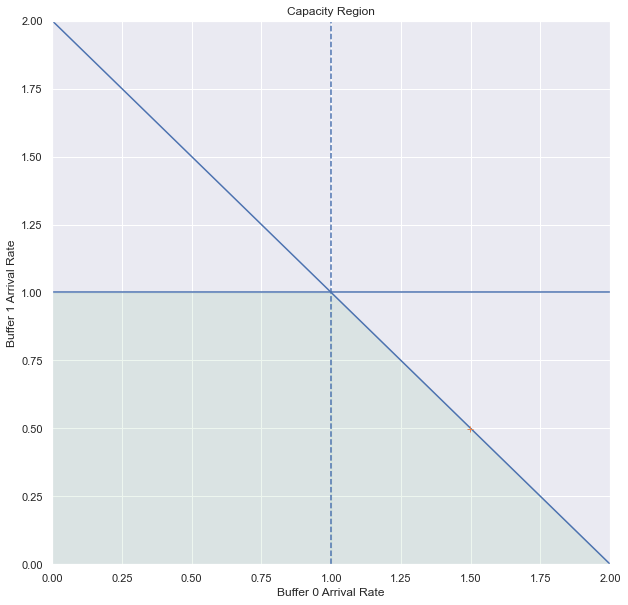




[0.9218470108486897, 0.786346440634749]
[-0.010091217428660926,
 0.008809468075792987,
 0.28563989617486996,
 -0.08938001089189057,
 -0.024079285517235646,
 0.0033628782865103533,
 0.01450974795588513,
 -0.014600429015524193,
 -0.0781529891513103]
[1, 0.786346440634749]


C:\ProgramData\Miniconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 70%
Progress: 80%
Progress: 90%
  Graph Index Direction epsilon                   alpha  Case  \
0         NaN   crp_tri   0.005                     NaN  good   
1         NaN   crp_tri   0.005                     NaN  good   
2         NaN   crp_tri   0.005                     NaN  good   
3         NaN   crp_tri   0.005                     NaN  good   
4         NaN   crp_tri   0.005  [1, 0.786346440634749]  good   
5         NaN   crp_tri   0.005  [1, 0.786346440634749]  good   

            Algorithm lambda_0 lambda_1      Avg Lq_0    Avg Lq_1  \
0           maxweight  1.49875  0.49625    199.638218  200.120621   
1  weighted_maxweight  1.49875  0.49625    265.724581  133.299815   
2                 cmu  1.49875  0.49625    397.697504     0.98905   
3          cmu_thresh  1.49875  0.49625    397.697504     0.98905   
4              random  1.49875  0.49625    396.964216    1.728245   
5   

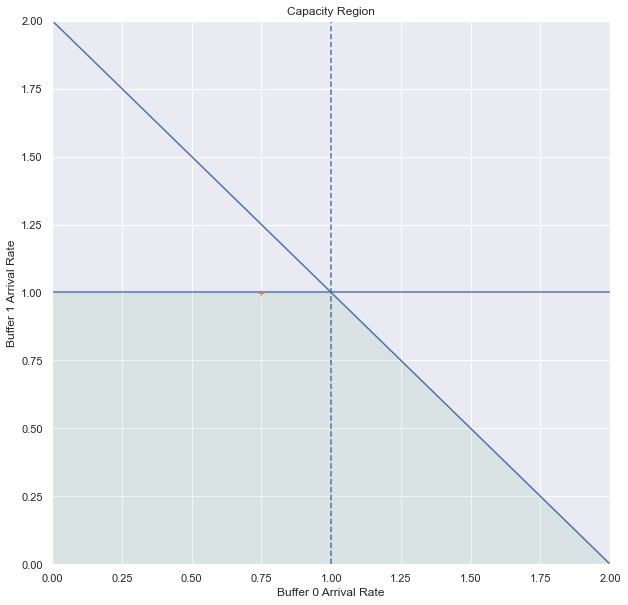




[0.9996171482625004, 1.1799489618678431]
[-0.003969380306607206,
 0.8407911224936975,
 -0.08220490421159117,
 -16.75321033724024,
 -0.03554465273680395,
 0.006949672930241759,
 -0.038605458813301394,
 -0.7879008396028067,
 -0.0003828517374996343]
[1, 1.1799489618678431]


C:\ProgramData\Miniconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 70%
Progress: 80%
Progress: 90%
  Graph Index Direction epsilon                    alpha  Case  \
0         NaN  crp_rect  0.2505                      NaN  good   
1         NaN  crp_rect  0.2505                      NaN  good   
2         NaN  crp_rect  0.2505                      NaN  good   
3         NaN  crp_rect  0.2505                      NaN  good   
4         NaN  crp_rect  0.2505  [1, 1.1799489618678431]  good   
5         NaN  crp_rect  0.2505  [1, 1.1799489618678431]  good   

            Algorithm lambda_0 lambda_1  Avg Lq_0     Avg Lq_1  Avg sum(Lq)  \
0           maxweight     0.75   0.9995  3.399159  1131.999047  1135.398206   
1  weighted_maxweight     0.75   0.9995  3.399159  1131.999047  1135.398206   
2                 cmu     0.75   0.9995  3.399159  1131.999047  1135.398206   
3          cmu_thresh     0.75   0.9995  3.399159  1131.999047  1135.398206   
4              r

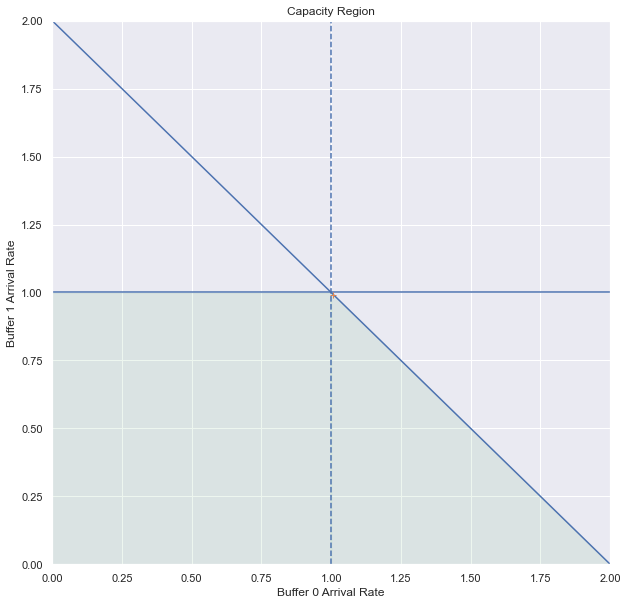




[0.999443452220616, 1.0005406948298565]
[0.21601642235691543,
 0.9824933605984371,
 0.00610053935679558,
 -97.09360332114751,
 -5.126533894873006,
 -0.00035925327875635824,
 0.6640591278394613,
 -0.5671354647416892,
 -0.0005565477793839646]
[1, 1.0005406948298565]


C:\ProgramData\Miniconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 70%
Progress: 80%
Progress: 90%
  Graph Index   Direction epsilon                    alpha  Case  \
0         NaN  noncrp_tri   0.005                      NaN  good   
1         NaN  noncrp_tri   0.005                      NaN  good   
2         NaN  noncrp_tri   0.005                      NaN  good   
3         NaN  noncrp_tri   0.005                      NaN  good   
4         NaN  noncrp_tri   0.005  [1, 1.0005406948298565]  good   
5         NaN  noncrp_tri   0.005  [1, 1.0005406948298565]  good   

            Algorithm lambda_0 lambda_1     Avg Lq_0    Avg Lq_1  Avg sum(Lq)  \
0           maxweight    1.005     0.99   201.097874  303.873239   504.971113   
1  weighted_maxweight    1.005     0.99   259.091986  204.575007   463.666994   
2                 cmu    1.005     0.99   366.524578   80.645731   447.170309   
3          cmu_thresh    1.005     0.99   366.524578   80.645731   447.17

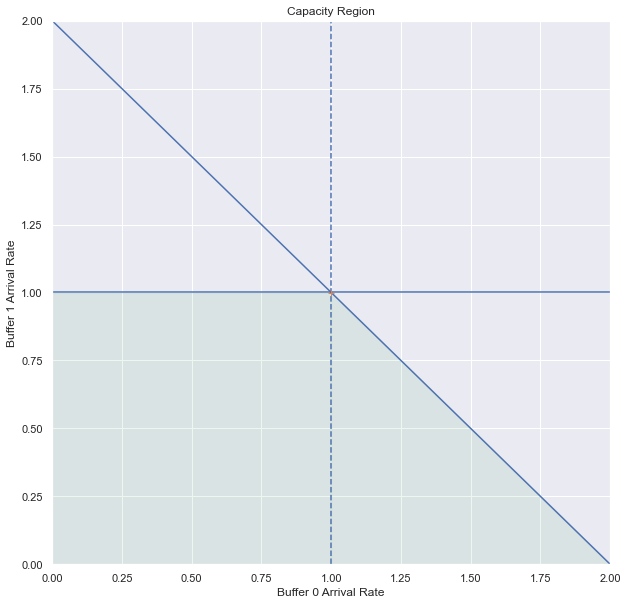




[0.9999757932854278, 1.0004044986396388]
[0.1439973776577972,
 0.04476658195360547,
 -0.0020721324816555474,
 11.557905290303014,
 0.09632606144002624,
 -1.3081161654474355e-05,
 0.03233841531385565,
 -0.20754175972595715,
 -2.420671457215029e-05]
[1, 1.0004044986396388]


C:\ProgramData\Miniconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 70%
Progress: 80%
Progress: 90%
  Graph Index    Direction epsilon                    alpha  Case  \
0         NaN  noncrp_rect   0.005                      NaN  good   
1         NaN  noncrp_rect   0.005                      NaN  good   
2         NaN  noncrp_rect   0.005                      NaN  good   
3         NaN  noncrp_rect   0.005                      NaN  good   
4         NaN  noncrp_rect   0.005  [1, 1.0004044986396388]  good   
5         NaN  noncrp_rect   0.005  [1, 1.0004044986396388]  good   

            Algorithm lambda_0 lambda_1    Avg Lq_0    Avg Lq_1 Avg sum(Lq)  \
0           maxweight   0.9975   0.9975  169.677127  709.359944  879.037071   
1  weighted_maxweight   0.9975   0.9975  201.277596  552.725745  754.003342   
2                 cmu   0.9975   0.9975  212.018437  503.341357  715.359794   
3          cmu_thresh   0.9975   0.9975  212.018437  503.341357  715.35979

In [5]:
out_time = int(time_lib.time())
out_i = 0
if to_folder:
    os.makedirs(f"{out_folder}\\{out_time}")
with open(f"{out_folder}\\{out_time}\\"*to_folder + "info.txt", "w") as file:
    for (label, data) in input_params.items():
        print(f"{label}:", data, file=file)
    
        
for n in ns:

    c = list(np.linspace(1, 2, num=n))
    pprint(c)
    
    for case in range(1 + ordered_costs):
        if ordered_costs:
            c.sort()
            if case == 0:
                if show_output:
                    print("Good Case: Queue 0 is least expensive.")
            else:
                continue
                if show_output:
                    print("Bad Case: Queue 0 is most expensive.")
                c = c[::-1]
    #     if type(gamma) == str and gamma == "cost":
    #         gamma = c
        
        for direction in directions:
            lambdas = []

            if not lamb_defined:

                if n == 2:
                    fig = plt.figure(figsize=[10, 10])
                    # plot capacity region w/ lambdas approaching facets
                    plt.fill_between([0, mu[0]], 0, mu[2], color='C2', alpha=0.1)
                    plt.fill_between([mu[0], mu[0] + mu[1]], 0, [mu[2], 0], color='C2', alpha=0.1)
                    plt.axhline(mu[2], xmin=0, xmax=mu[0])
                    plt.axvline(mu[0], ymin=0, ymax=mu[2], linestyle="dashed")
                    plt.plot([0, mu[0]+mu[1]], [mu[2] + mu[0]*mu[2]/mu[1], 0])
                    plt.xlim([0, (mu[0]+mu[1])])
                    plt.ylim([0, (mu[2] + mu[0]*mu[2]/mu[1])])

                    # what direction do we approach heavy traffic limit
                    if direction == "noncrp_rect":
                        slope = mu[2] / mu[0]
                        for epsilon in epsilons:
                                lambdas.append((mu[0] * (1-epsilon/2), slope * mu[0] * (1-epsilon/2)))
                                plt.plot(lambdas[-1][0], lambdas[-1][1], marker="+")
                    if direction == "crp_tri":
                        slope = (mu[0]+mu[1]) / (mu[2] + mu[0]*mu[2]/mu[1])
                        intercept = mu[2]/2 - (mu[0]+mu[1]/2) * slope
                        for epsilon in epsilons:
                                lambdas.append((mu[0]+ mu[1] / 2 * (1-epsilon/2), intercept + slope * (mu[0]+mu[1]/2) * (1-epsilon/2)))
                                plt.plot(lambdas[-1][0], lambdas[-1][1], marker="+")
                    if direction == "crp_rect":
                        for epsilon in epsilons:
                                lambdas.append((3*mu[0]/4, mu[2] * (1-epsilon/10)))
                                plt.plot(lambdas[-1][0], lambdas[-1][1], marker="+")
                    if direction == "noncrp_tri":
                        for epsilon in epsilons:
                                lambdas.append((mu[0] + epsilon*2 * mu[1]/2, mu[2] * (1-epsilon*2)))
                                plt.plot(lambdas[-1][0], lambdas[-1][1], marker="+")

                    plt.xlabel("Buffer 0 Arrival Rate")
                    plt.ylabel("Buffer 1 Arrival Rate")
                    plt.title("Capacity Region")
                    plt.savefig(f"{out_folder}\\{out_time}\\"*to_folder + f"region_{direction}.png")
                    if show_output:
                        plt.show()
                        print("\n\n")

                else:
                    # randomly select lambdas that will be stable
                    for i in range(len(algs)):
                        lamb = [np.random.uniform(mu[0], 1.5*mu[0])]
                        for i in range(1, n):
                            lamb.append(np.random.uniform(0.75 * (mu[2*i]-(lamb[i-1]-mu[2*(i-1)])), mu[2*i]-(lamb[i-1]-mu[2*(i-1)])))
                        lambdas.append(lamb)

            else:
                for epsilon in epsilons:
                    lambdas.append([1-epsilon for j in range(n)])

            for lamb in lambdas:
    #             if n == 2:
    #                 epsilon = abs((1-lamb[1]/mu[2]) - (lamb[0]-mu[0])/mu[1])
    #             else:
    #             epsilon = 1 - sum(lamb) / sum(mu[::2])
                if not lamb_defined:
                    epsilon = sum(mu[::2]) - sum(lamb)
                else:
                    epsilon = epsilons[lambdas.index(lamb)]
    #             print(epsilon)


                # initializing variables
                if time_mode == "continuous":
                    rng1 = np.random.default_rng(100)
                    rng2 = np.random.default_rng(200)
                    rng3 = np.random.default_rng(300)
                elif time_mode == "discrete":
                    rng1 = [np.random.default_rng(100 + j) for j in range(n)]
                    rng2 = [np.random.default_rng(200 + act) for act in range(2*n-1)]
                    rng3 = np.random.default_rng(300)
                    unused_tallys = [[0 for j in range(n)] for alg_index in range(num_algs)]

                # for threshold algs
                Lr = [[110, 330][lambdas.index(lamb)] for j in range(n-1)]#[c[j+1]/c[j] * 120 * np.log(1/epsilon) for j in range(n-1)] # used to be 75
                # for best random alg
                alpha = randOptimize()
                pprint(alpha)
#                 pprint(lamb)

                # initializing statistics
                if graph:
                    event_time_stats = [[] for alg_index in range(num_algs)]
                    Lq_stats = [[] for alg_index in range(num_algs)]
                if graph_dist and n == 2:
                    Lq_freqs = [{} for alg_index in range(num_algs)]
                elif graph_dist:
                    Lq_freqs = [[{} for j in range(n)] for alg_index in range(num_algs)]
                decisions = [[1 for i in range(n)] for alg_index in range(num_algs)]
                Lqs = [[0 for i in range(n)] for alg_index in range(num_algs)]
                times = [0 for alg_index in range(num_algs)]
                Lq_tallys = [[0 for j in range(n)] for alg_index in range(num_algs)]
                
#                 sum_Lq_tallys = [0 for alg_index in range(num_algs)]
#                 sum_weighted_Lq_tallys = [0 for alg_index in range(num_algs)]

                # beginning run
                for iteration in range(duration):
                    if iteration % (duration // 10) == 0 and iteration > 0:
                        print(f"Progress: {(iteration // (duration // 10))*10}%")
                    if time_mode == "continuous":
                        # combining process rates
                        denominators = [sum(lamb) + (Lqs[alg_index][0] > 0) * mu[0] + sum([(Lqs[alg_index][i] > 0 and decisions[alg_index][i+1] == 0) * mu[2*(i+1)-1] +
                                            (Lqs[alg_index][i+1] > 0 and decisions[alg_index][i+1] == 1) * mu[2*(i+1)] for i in range(n-1)]) for alg_index in range(num_algs)]
                        
                        prob = rng1.uniform(0, 1)
                        interarrival_times = [-denominators[alg_index]*np.log(1-prob) for alg_index in range(num_algs)]

                        # record state to statistic
                        if iteration > warmup_period * duration:
                            for alg_index in range(num_algs):
                                for j in range(n):
                                    Lq_tallys[alg_index][j] = Lq_tallys[alg_index][j]*times[alg_index]/(times[alg_index]+interarrival_times[alg_index]) + (Lqs[alg_index][j] * interarrival_times[alg_index]) / (times[alg_index] + interarrival_times[alg_index])
#                                 sum_Lq_tallys[alg_index] += sum(Lqs[alg_index]) * interarrival_times[alg_index]
#                                 sum_weighted_Lq_tallys[alg_index] += sum([c[j]*Lqs[alg_index][j] for j in range(n)]) * interarrival_times[alg_index]
                                times[alg_index] += interarrival_times[alg_index]
                                if graph:
                                    event_time_stats[alg_index].append(times[alg_index])
                                    Lq_stats[alg_index].append(copy.deepcopy(Lqs[alg_index]))


                        # check what this event represents, do appropriate action
                        prob = rng2.uniform(0, 1)
                        for alg_index in range(num_algs):
                            prob_copy = prob
                            for j in range(n):
                                prob_copy -= lamb[j] / denominators[alg_index]
                                if prob_copy < 0:
                                    Lqs[alg_index][j] += 1
                                    break
                            if prob_copy > 0:
                                prob_copy -= (Lqs[alg_index][0] > 0) * mu[0] / denominators[alg_index]
                                if prob_copy < 0:
                                    Lqs[alg_index][0] -= 1
                            for j in range(n-1):
                                if prob_copy > 0:
                                    prob_copy -= (Lqs[alg_index][j] > 0 and decisions[alg_index][j+1] == 0) * mu[2*(j+1)-1] / denominators[alg_index]
                                    if prob_copy < 0:
                                        Lqs[alg_index][j] -= 1
                                        break
                                if prob_copy > 0:
                                    prob_copy -= (Lqs[alg_index][j+1] > 0 and decisions[alg_index][j+1] == 1) * mu[2*(j+1)] / denominators[alg_index]
                                    if prob_copy < 0:
                                        Lqs[alg_index][j+1] -= 1
                                        break

                    elif time_mode == "discrete":
                        time += 1

                        # num arrivals per buffer
                        for j in range(n):
                            Lqs[alg_index][j] += rng1[j].poisson(lamb[j])

                        # num services for each buffer
                        Lqs[alg_index][0] -= rng2[0].poisson(mu[0])
                        for j in range(1, n):
                            if alg == "random":
                                Lqs[alg_index][j-1] -= rng2[2*j-1].poisson((1-alpha[j]) * mu[2*j-1])
                                Lqs[alg_index][j] -= rng2[2*j].poisson((alpha[j]) * mu[2*j])
                            elif alg == "maxweight":
                                Lqs[alg_index][j-1] -= round((1-alpha_maxweight[j]) * rng2[2*j-1].poisson(mu[2*j-1]))
                                Lqs[alg_index][j] -= round((alpha_maxweight[j]) * rng2[2*j].poisson(mu[2*j]))
                            else:
                                Lqs[alg_index][j-1] -= (decisions[alg_index][j] == 0) * rng2[2*j-1].poisson(mu[2*j-1])
                                Lqs[alg_index][j] -= (decisions[alg_index][j] == 1) * rng2[2*j].poisson(mu[2*j])

                        # ensure positive buffers
                        for j in range(n):
                            if Lqs[alg_index][j] < 0:
                                unused_tallys[alg_index][j] = - Lqs[alg_index][j]
                                Lqs[alg_index][j] = 0

                    # changes servers' priority by the policy
                    for alg_index in range(num_algs):
                        alg = algs[alg_index]
                        for i in range(1, n):
                            if Lqs[alg_index][i-1] == 0 and time_mode == "continuous" and "idle" not in alg:
                                decisions[alg_index][i] = 1
                            elif Lqs[alg_index][i] == 0 and time_mode == "continuous" and "idle" not in alg:
                                decisions[alg_index][i] = 0
                            else:
                                if "maxweight" in alg:
                                    if "weighted" in alg:
                                        gamma = c
                                    else:
                                        gamma = [1 for j in range(n)]
                                    decisions[alg_index][i] = int(gamma[i] * Lqs[alg_index][i] ** beta * mu[2*i] >
                                                                  gamma[i-1] * Lqs[alg_index][i-1] ** beta * mu[2*i-1])
                                elif "random" in alg:
                                    decisions[alg_index][i] = int(rng3.uniform(0,1) < alpha[i]) # applies only if continuous time
    #                                 decision[i] = int(rng3.uniform(0,1) < lamb[i] / mu[2*i-1])
                                elif alg == "prioritize_right":
                                    decisions[alg_index][i] = 1
                                elif "cmu" in alg:
                                    decisions[alg_index][i] = int(c[i] * mu[2*i] > c[i-1] * mu[2*i-1])
    #                                     if alg == "cmu_multi_thresh" or (alg == "cmu_single_thresh" and i == 1):
                                    if "thresh" in alg:
    #                                         if decisions[alg_index][i] == 0 and Lqs[alg_index][i-1] <= Lr[i-1]:
    #                                             decisions[alg_index][i] = 1
    #                                         if decisions[alg_index][i] == 1 and Lqs[alg_index][i-1] > Lr[i-1]:
    #                                             decisions[alg_index][i] = 0
                                        if Lqs[alg_index][i-1] <= Lr[i-1]:
                                            decisions[alg_index][i] = 1
    #                                 elif alg == "threshold":
    #                                     if Lqs[alg_index][i-1] <= Lr[i-1]:
    #                                         decisions[alg_index][i] = 1
    #                                     if Lqs[alg_index][i-1] > Lr[i-1]:
    #                                         decisions[alg_index][i] = 0

                        # maxweight optimization if applicable
#                         if "maxweight" in alg and time_mode == "continuous" and n > 2:
#                             if "weighted" in alg:
#                                 gamma = c
#                             else:
#                                 gamma = [1 for j in range(n)]
# #                             decisions[alg_index] = MaxWeight()
#                             obj_vals = []
#                             for i in range(2**(n-1)):
#                                 x = [1] + [0 for r in range((n-1)-(len(bin(i))-2))] + [int(b) for b in bin(i)[2:]]
#                                 obj_vals.append(sum([gamma[j] * Lqs[alg_index][j] ** beta * ((x[j])*mu[2*j] + (1-x[j+1])*mu[2*(j+1)-1]) for j in range(n-1)]) + gamma[n-1] * Lqs[alg_index][n-1] ** beta * ((x[n-1])*mu[2*(n-1)]))
#                             best = np.argmax(obj_vals)
#                             decisions[alg_index] = [1] + [0 for r in range((n-1)-(len(bin(best))-2))] + [int(b) for b in bin(best)[2:]]
#                         elif "maxweight" in alg and time_mode == "discrete":
#                             if "weighted" in alg:
#                                 gamma = c
#                             else:
#                                 gamma = [1 for j in range(n)]
#                             alpha_maxweight = MaxWeight()
                            
                        # record distribution frequencies if applicable
                        if iteration > warmup_period * duration and graph_dist:
                            if n == 2:
                                if tuple(Lqs[alg_index]) not in Lq_freqs[alg_index].keys():
                                    Lq_freqs[alg_index][tuple(Lqs[alg_index])] = 0
                                Lq_freqs[alg_index][tuple(Lqs[alg_index])] += 1
                            else:
                                for j in range(n):
                                    if j > 0:
                                        if alg == "maxweight":
                                            term = Lqs[alg_index][j] - Lqs[alg_index][j-1]
                                        elif alg == "weighted_maxweight":
                                            term = 2 * Lqs[alg_index][j] - Lqs[alg_index][j-1]
                                        else:
                                            term = Lqs[alg_index][j]
                                    else:
                                        term = Lqs[alg_index][j]
                                    if term not in Lq_freqs[alg_index][j].keys():
                                        Lq_freqs[alg_index][j][term] = 0
                                    Lq_freqs[alg_index][j][term] += 1
                                        

                # initialize subplots and table
                avg_df = pd.DataFrame(columns=["Graph Index", "Direction", "epsilon", "alpha", "Case", "Algorithm"] + [f"lambda_{j}" for j in range(max(ns))] + [f"Avg Lq_{j}" for j in range(max(ns))] + ["Avg sum(Lq)", "Avg Cost-Weighted sum(Lq)"]) # index=range(len(algs)), 
                if graph:
                    fig_Lq, axs_Lq = plt.subplots(len(algs) // 2, 2, sharex=False, sharey=False)


                
                # initialize joint dist plots
                if graph_dist and n == 2:
                    fig_dist = plt.figure()
                    subfigs_dist = fig_dist.subfigures(len(algs) // 2, 2, wspace=0.07)
                    if "maxweight" in algs and "weighted_maxweight" in algs:
                        fig_dist_alt = plt.figure()
                        subfigs_dist_alt = fig_dist_alt.subfigures(1, 2, wspace=0.07)
                elif graph_dist:
                    fig_dist = plt.figure()
                    subfigs_dist = fig_dist.subfigures(len(algs) // 2, 2, wspace=0.07)
                   
                            
                # plot queue lengths
                for alg_index in range(num_algs):
                    alg = algs[alg_index]
                    if graph:
                        for j in range(n):
                            axs_Lq[alg_index // 2, alg_index % 2].plot(event_time_stats[alg_index], [Lq[j] for Lq in Lq_stats[alg_index]], label = f"Lq_{j}", color=color_dict[j])
                        if "thresh" in alg:
                            for j in range(n-1):
                                axs_Lq[alg_index // 2, alg_index % 2].axhline(Lr[j], xmin=0, xmax=times[alg_index], label = f"Lr_{j}", linestyle="dotted", color=color_dict[j], alpha=0.6)
                        axs_Lq[alg_index // 2, alg_index % 2].legend()
                        axs_Lq[alg_index // 2, alg_index % 2].set(ylabel="Queue Length", xlabel="Time")
                        axs_Lq[alg_index // 2, alg_index % 2].set_title(alg)

                    if graph_dist and n == 2:
#                         pprint([Lq_0 for (Lq_0, Lq_1) in Lq_freqs[alg_index].keys()])
#                         pprint([Lq_1 for (Lq_0, Lq_1) in Lq_freqs[alg_index].keys()])
#                         pprint(Lq_freqs[alg_index].values())
                        df = pd.DataFrame({"Lq_0":[Lq_0 for (Lq_0, Lq_1) in Lq_freqs[alg_index].keys()], "Lq_1":[Lq_1 for (Lq_0, Lq_1) in Lq_freqs[alg_index].keys()], "weights":list(Lq_freqs[alg_index].values())})
                        x_range = (min(df["Lq_0"]), max(df["Lq_0"]))
                        y_range = (min(df["Lq_1"]), max(df["Lq_1"]))
                        x_bins = min(50, len(df["Lq_0"]))
                        y_bins = min(50, len(df["Lq_1"]))
                        axs = subfigs_dist[alg_index // 2, alg_index % 2].subplots(2, 2, sharex=False, sharey=False, gridspec_kw={'height_ratios': [1, 3], 'width_ratios': [3, 1], 'wspace':0, 'hspace':0})
                        axs[1, 0].hist2d(df["Lq_0"], df["Lq_1"], weights=df["weights"], bins=(x_bins, y_bins), range=(x_range, y_range), density=False, cmin=0, cmap=afmhot_with0)
                        axs[1, 0].set(ylabel="Lq_1", xlabel="Lq_0")
                        axs[0, 0].hist(df["Lq_0"], weights=df["weights"], bins=x_bins, range=x_range, density=True)
                        axs[0, 0].set_xticklabels([])
                        axs[0, 0].set_yticklabels([])
                        axs[1, 1].hist(df["Lq_1"], weights=df["weights"], bins=y_bins, range=y_range, density=True, orientation="horizontal")
                        axs[1, 1].set_xticklabels([])
                        axs[1, 1].set_yticklabels([])
                        subfigs_dist[alg_index // 2, alg_index % 2].suptitle(alg)
                        subfigs_dist[alg_index // 2, alg_index % 2].delaxes(axs[0, 1])
        
                        x_range = (min(df["Lq_0"]), max(df["Lq_0"]))
                        y_range = (min([df["Lq_1"][i] - df["Lq_0"][i] for i in range(len(df))]), max([df["Lq_1"][i] - df["Lq_0"][i] for i in range(len(df))]))
                        x_bins = min(50, len(df["Lq_0"]))
                        y_bins = min(50, len(df["Lq_1"]))
                        axs_alt = subfigs_dist_alt[alg_index // 2, alg_index % 2].subplots(2, 2, sharex=False, sharey=False, gridspec_kw={'height_ratios': [1, 3], 'width_ratios': [3, 1], 'wspace':0, 'hspace':0})
                        axs_alt[1, 0].hist2d(df["Lq_0"], [df["Lq_1"][i] - df["Lq_0"][i] for i in range(len(df))], weights=df["weights"], bins=(x_bins, y_bins), range=(x_range, y_range), density=False, cmin=0, cmap=afmhot_with0)
                        axs_alt[1, 0].set(ylabel="Lq_1-Lq_0", xlabel="Lq_0")
                        axs_alt[0, 0].hist(df["Lq_0"], weights=df["weights"], bins=x_bins, range=x_range, density=True)
                        axs_alt[0, 0].set_xticklabels([])
                        axs_alt[0, 0].set_yticklabels([])
                        axs_alt[1, 1].hist([df["Lq_1"][i] - df["Lq_0"][i] for i in range(len(df))], weights=df["weights"], bins=y_bins, range=y_range, density=True, orientation="horizontal")
                        axs_alt[1, 1].set_xticklabels([])
                        axs_alt[1, 1].set_yticklabels([])
                        subfigs_dist_alt[alg_index // 2, alg_index % 2].suptitle(alg)
                        subfigs_dist_alt[alg_index // 2, alg_index % 2].delaxes(axs_alt[0, 1])
                        
                    elif graph_dist:
                        axs = subfigs_dist[alg_index // 2, alg_index % 2].subplots(1, n, sharex=False, sharey=False, gridspec_kw={'wspace':0.35, 'hspace':0})
                        for j in range(n):
#                             if alg == "maxweight":
#                                 data = [Lq for Lq in Lq_freqs[alg_index][j].keys()]
#                             elif alg == "weighted_maxweight":
#                             else:
                            data = [Lq for Lq in Lq_freqs[alg_index][j].keys()]
                            weights = list(Lq_freqs[alg_index][j].values())
                            bins = min(50, len(data))
                            
                            axs[j].hist(data, weights=weights, bins=bins, density=True, orientation="horizontal")
                            axs[j].set(xlabel=f"Lq_{j}")
                            axs[j].set_xticklabels([])
#                             axs[j].set_yticklabels(axs[j].get_yticklabels(), rotation = 90)
                            axs[j].yaxis.set_major_formatter(FormatStrFormatter('%d'))
                            for tick in axs[j].get_yticklabels():
                                tick.set_rotation(-90)
                        subfigs_dist[alg_index // 2, alg_index % 2].suptitle(alg)

                    # populate avgs table with run results
                    if graph or graph_dist:
                        avg_df.loc[alg_index, "Graph Index"] = out_i
                    if direction != 1:
                        avg_df.loc[alg_index, "Direction"] = direction
                    avg_df.loc[alg_index, "epsilon"] = epsilon
                    if "random" in alg:
                        avg_df.at[alg_index, "alpha"] = alpha
                    if ordered_costs:
                        avg_df.loc[alg_index, "Case"] = "good" if (case == 0) else "bad"
                    avg_df.loc[alg_index, "Algorithm"] = alg
                    for j in range(n):
                        avg_df.loc[alg_index, f"lambda_{j}"] = lamb[j]
                        avg_df.loc[alg_index, f"Avg Lq_{j}"] = Lq_tallys[alg_index][j] #np.mean([Lq[j] for Lq in Lq_stat])
                    avg_df.loc[alg_index, "Avg sum(Lq)"] = sum(Lq_tallys[alg_index])#sum_Lq_tallys[alg_index]/(times[alg_index]) #np.mean([sum(Lq) for Lq in Lq_stat])
                    avg_df.loc[alg_index, "Avg Cost-Weighted sum(Lq)"] = sum([c[j] * Lq_tallys[alg_index][j] for j in range(n)]) #sum_weighted_Lq_tallys[alg_index]/(times[alg_index]) # np.mean([sum([c[i] * Lq[i] for i in range(n)]) for Lq in Lq_stat])

                # display or save multigraphs and tables w/ all algorithm outputs
#                 os.makedirs(f"{out_folder}\\{out_time}\\{out_i}")
#                 result_dict = {"epsilon":round(epsilon, 4), "direction":direction, "good case":(case == 0)}
#                 with open(f"{out_folder}\\{out_time}\\{out_i}\\info.txt", "w") as file:
#                     for (label, data) in result_dict.items():
#                         print(f"{label}:", data, file=file)
#                     print(avg_df, file=file)
#                     print(list(avg_df["Avg Cost-Weighted sum(Lq)"]), file=file)
                
#                 csv_filename = f"{out_folder}\\{out_time}\\{str(round(epsilon, 5)).replace('.', '_')}.csv"
#                 avg_df.to_csv(csv_filename, mode="a", header= (not os.path.exists(csv_filename)), index=False)
                csv_filename = f"{out_folder}\\{out_time}\\"*to_folder + "results.csv"
                avg_df.to_csv(csv_filename, mode="a", header= (not os.path.exists(csv_filename)), index=False)


                if graph:
                    fig_Lq.suptitle(f"Epsilon {round(epsilon, 3)} Queue Length", fontsize="xx-large", y=0.94)
                    fig_Lq.savefig(f"{out_folder}\\{out_time}\\"*to_folder + f"{out_i}_Lq.png", bbox_inches="tight")
                if graph_dist:
                    fig_dist.suptitle(f"Epsilon {round(epsilon, 3)} Joint Distribution", fontsize="xx-large", y=0.94)
                    fig_dist.savefig(f"{out_folder}\\{out_time}\\"*to_folder + f"{out_i}_dist.png")
                    if n == 2:
                        fig_dist_alt.suptitle(f"Epsilon {round(epsilon, 3)} Joint Distribution (Alternate)", fontsize="xx-large", y=0.94)
                        fig_dist_alt.savefig(f"{out_folder}\\{out_time}\\"*to_folder + f"{out_i}_dist_alt.png")
                if show_output:
                    if graph:
                        display(fig_Lq)
                        print("\n\n")
                    if graph_dist:
                        display(fig_dist)
                        print("\n\n\n")
                        if n ==2:
                            display(fig_dist_alt)
                    pprint(avg_df)
                    print("\n\n")
                out_i += 1


                plt.close("all")
                        
with open(f"{out_folder}\\{out_time}\\"*to_folder + "info.txt", "a") as file:
    print("Run time:", int(time_lib.time()) - out_time, "seconds", file=file)